In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tariffs = pd.read_csv('/Users/marina/Downloads/Задание_3/Tariff_plans_change.csv')
charges = pd.read_csv('/Users/marina/Downloads/Задание_3/Charges.csv')
suspended = pd.read_csv('/Users/marina/Downloads/Задание_3/Suspended.csv').drop(columns='STATUS')

In [3]:
tariffs = tariffs.assign(status = lambda tariffs: np.where(tariffs["END_DTTM"] == "$null$", "finish", "start")) 

tariffs['START_DTTM'] = pd.to_datetime(tariffs['START_DTTM'])

#таблица начальных тарифов 
start_tariffs = tariffs[tariffs['status'] == 'start'][['SUBSCRIBER_ID', 'TARIFF_PLAN_ID','START_DTTM']] \
    .rename(columns={'TARIFF_PLAN_ID':'Start_Tariff_ID','START_DTTM':'STariff_activated'})

#таблица конечных тарифов 

finish_tariffs = tariffs[tariffs['status'] == 'finish'][['SUBSCRIBER_ID', 'TARIFF_PLAN_ID', 'START_DTTM']] \
    .rename(columns={'TARIFF_PLAN_ID':'Finish_Tariff_ID','START_DTTM':'FTariff_activated'})

1. Насколько реже или чаще стали попадать в блокировки абоненты после миграции в целом и для каждого направления миграции в отдельности. 

Для сравнения использовать те же периоды: 3 месяца до месяца смены плана и 3 месяца после месяца смены.

In [11]:
suspended['START_DT'] = pd.to_datetime(suspended['START_DT'])

res = suspended.merge(start_tariffs, on = 'SUBSCRIBER_ID') \
         .merge(finish_tariffs, on = 'SUBSCRIBER_ID') \
         .assign(Current_tariff = np.where(res['START_DT'] > res['FTariff_activated'], res['Finish_Tariff_ID'], res['Start_Tariff_ID']),
                Tariff_migration = res['Start_Tariff_ID'].astype(str) + ' -> ' + res['Finish_Tariff_ID'].astype(str),
                 Diff_date = (res['FTariff_activated'] - suspended['START_DT']).dt.days ) \
          .drop(['STariff_activated', 'FTariff_activated'], axis=1)


In [16]:
 locks = res.loc[(res['Diff_date'] > - 92) & (res['Diff_date'] < 92)] \
       .groupby(['SUBSCRIBER_ID', 'Current_tariff', 'Tariff_migration', 'Start_Tariff_ID', 'Finish_Tariff_ID'], as_index=False)['START_DT'].count() \
       .rename(columns = {'SUBSCRIBER_ID':'Sub_ID', 'START_DT':'Locks_count'}) \
       .assign(Locks_diff = np.where(locks['Current_tariff'] != locks['Finish_Tariff_ID'], 0 - locks['Locks_count'], locks['Locks_count'])) 


In [17]:
locks = locks.groupby(['Sub_ID', 'Tariff_migration', 'Start_Tariff_ID', 'Finish_Tariff_ID'], as_index=False)['Locks_diff'].sum() \
    .groupby(['Tariff_migration', 'Start_Tariff_ID', 'Finish_Tariff_ID'],as_index=False).agg({'Sub_ID':'count', 'Locks_diff':'mean'}) 

In [18]:
totals = res.loc[(res['Diff_date'] > - 92) & (res['Diff_date'] < 92)]
positive_count = totals[totals['Diff_date'] > 0]['START_DT'].count()
negative_count = totals[totals['Diff_date'] < 0]['START_DT'].count()

mean1 = totals[totals['Diff_date'] < 0].groupby('Tariff_migration', as_index = False)['START_DT'].count()
mean1 = round(mean1['START_DT'].mean(),2)
mean2 = totals[totals['Diff_date'] > 0].groupby('Tariff_migration', as_index = False)['START_DT'].count()
mean2 = round(mean2['START_DT'].mean(),2)

median = round(locks['Locks_diff'].median(),2)
print(f'Количество всех блокировок ДО изменений тарифа: {negative_count}')
print(f'Количество всех блокировок ПОСЛЕ изменений тарифа: {positive_count}')
print(f'Среднее число блокировок по всем направлениям миграции за 3 месяца до перехода: {mean1}')
print(f'Среднее число блокировок по всем направлению миграции через 3 месяца на новом тарифе: {mean2}')

Количество всех блокировок ДО изменений тарифа: 706
Количество всех блокировок ПОСЛЕ изменений тарифа: 758
Среднее число блокировок по всем направлениям миграции за 3 месяца до перехода: 33.62
Среднее число блокировок по всем направлению миграции через 3 месяца на новом тарифе: 37.9


/var/folders/th/prg8z3510zg7034rx9vyrvjm0000gn/T/ipykernel_2973/1620085598.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, locks[('Sub_ID')].max() * 1.1)


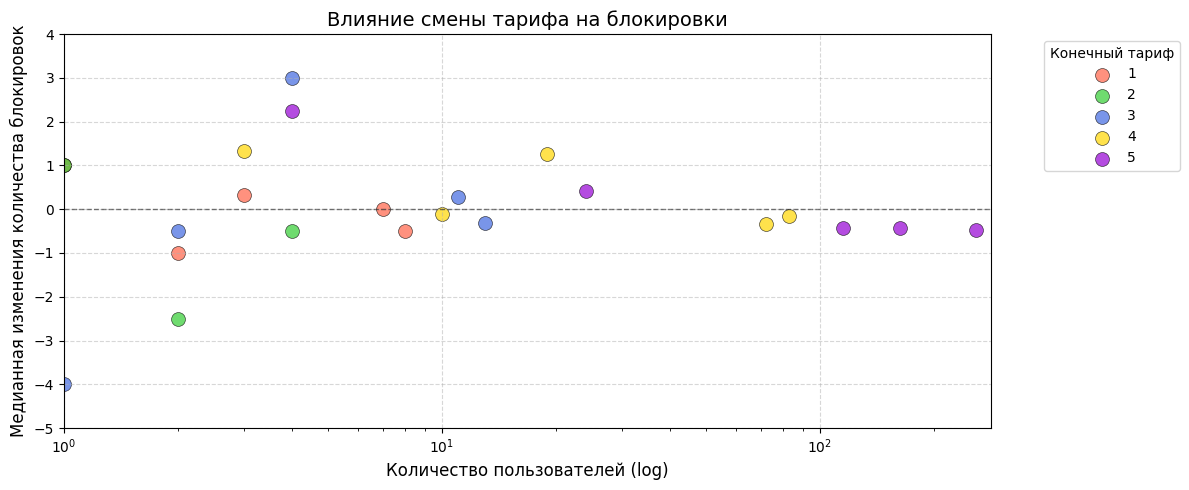

In [19]:
def rgba_to_hex(rgba_str):
    rgba_str = rgba_str.replace("rgba(", "").replace(")", "")
    r, g, b, a = map(float, rgba_str.split(","))
    return "#{:02x}{:02x}{:02x}".format(int(r), int(g), int(b))

tariff_colors = {
    1: rgba_to_hex("rgba(255, 99, 71, 0.8)"),  # Tomato
    2: rgba_to_hex("rgba(50, 205, 50, 0.8)"),  # LimeGreen
    3: rgba_to_hex("rgba(65, 105, 225, 0.8)"),  # RoyalBlue
    4: rgba_to_hex("rgba(255, 215, 0, 0.8)"),   # Gold
    5: rgba_to_hex("rgba(148, 0, 211, 0.8)")    # DarkViolet
}

# Создаем scatter plot
plt.figure(figsize=(12, 5))

scatters = []  # Будем хранить здесь scatter-объекты для настройки аннотаций
tariff_labels = []  

# Рисуем точки для каждого finish_tariff
for finish, group in locks.groupby('Tariff_migration'):
    plt.scatter(
        x=group[('Sub_ID')], 
        y=group[('Locks_diff')],
        s=100,  # Фиксированный размер точек (можно заменить на group['users_count']/10 для масштабирования)
        c=tariff_colors[int(finish[-1])],
        label=f'Миграция {finish}',
        alpha=0.7,
        edgecolors='black',  # Черная обводка для лучшей видимости
        linewidths= 0.5
    )

plt.xscale('log')
plt.xlim(1, 10**4)
# Настройки осей и сетки
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)  # Линия y=0
plt.xlabel('Количество пользователей (log)', fontsize=12)
plt.ylabel('Медианная изменения количества блокировок', fontsize=12)
plt.title('Влияние смены тарифа на блокировки', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Легенда и подписи
plt.legend(title='Конечный тариф', bbox_to_anchor=(1.05, 1), loc='upper left', labels = (1,2,3,4,5))

#Автоматическое масштабирование осей с запасом
plt.xlim(0, locks[('Sub_ID')].max() * 1.1)
y_min = locks[('Locks_diff')].min() - 1
y_max = locks[('Locks_diff')].max() + 1
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

Что видим на графике: люди перешедшие тариф 1 (оранж) в среднем почти не поменяли свою ситуцию, от +1 до -1 блокировоки. Больше всего пользователей перешли на тариф 5, сама группа больше, и не считая выбросов они тоже в зоне +1 и -1. 

2. Насколько изменился среднемесячный счет абонентов за период 3 месяца после месяца смены тарифного плана в сравнении с периодом 3 месяца до месяца смены тарифного плана. 

Какие направления смен тарифных планов характеризовались ростом среднего счета в трехмесячном периоде, а какие – сокращением.  Визуализировать результаты на диаграммах.

In [20]:
charges['BILL_MONTH'] = pd.to_datetime(charges['BILL_MONTH'])

In [87]:
charges_per_t = charges.merge(start_tariffs, on = 'SUBSCRIBER_ID') \
           .merge(finish_tariffs, on = 'SUBSCRIBER_ID') \
           .assign(Current_tariff = np.where(charges_per_t['BILL_MONTH'] > charges_per_t['FTariff_activated'], charges_per_t['Finish_Tariff_ID'], charges_per_t['Start_Tariff_ID']),
                    Tariff_migration = charges_per_t['Start_Tariff_ID'].astype(str) + ' -> ' + charges_per_t['Finish_Tariff_ID'].astype(str),
                    Diff_date = (charges_per_t['FTariff_activated'] - charges_per_t['BILL_MONTH']).dt.days ) \
           .drop(['STariff_activated', 'FTariff_activated'], axis=1) 

In [88]:
charges_per_t = charges_per_t.query('Diff_date > - 92 & Diff_date < 92') \
                             .assign(Average_before = charges_per_t[(charges_per_t['Diff_date'] < 0) & (charges_per_t['Diff_date'] > - 92)].groupby('SUBSCRIBER_ID')['CHARGES'].transform('mean'),
                             Average_after = charges_per_t[(charges_per_t['Diff_date'] > 0) & (charges_per_t['Diff_date'] < 92)].groupby('SUBSCRIBER_ID')['CHARGES'].transform('mean'))

In [89]:
charges_per_t['Average_before'] =  charges_per_t.groupby('SUBSCRIBER_ID')['Average_before'].transform(lambda x: x.fillna(x.mean()))
charges_per_t['Average_after'] =  charges_per_t.groupby('SUBSCRIBER_ID')['Average_after'].transform(lambda x: x.fillna(x.mean()))

charges_per_t['Charges_delta'] = charges_per_t['Average_after'] - charges_per_t['Average_before']

In [105]:
new_t = charges_per_t.groupby(['SUBSCRIBER_ID', 'Tariff_migration', 'Average_before','Average_after', 'Charges_delta'], as_index=False).first()[['SUBSCRIBER_ID', 'Tariff_migration', 'Average_before','Average_after', 'Charges_delta']]

In [106]:
new_t = new_t.groupby(['Tariff_migration'], as_index=False).agg( 
     ({'SUBSCRIBER_ID': 'nunique', 'Charges_delta' : 'median', 'Average_before' :'mean', 'Average_after': 'mean'})) 


/var/folders/th/prg8z3510zg7034rx9vyrvjm0000gn/T/ipykernel_2973/601594843.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, new_t['SUBSCRIBER_ID'].max() * 1.1)


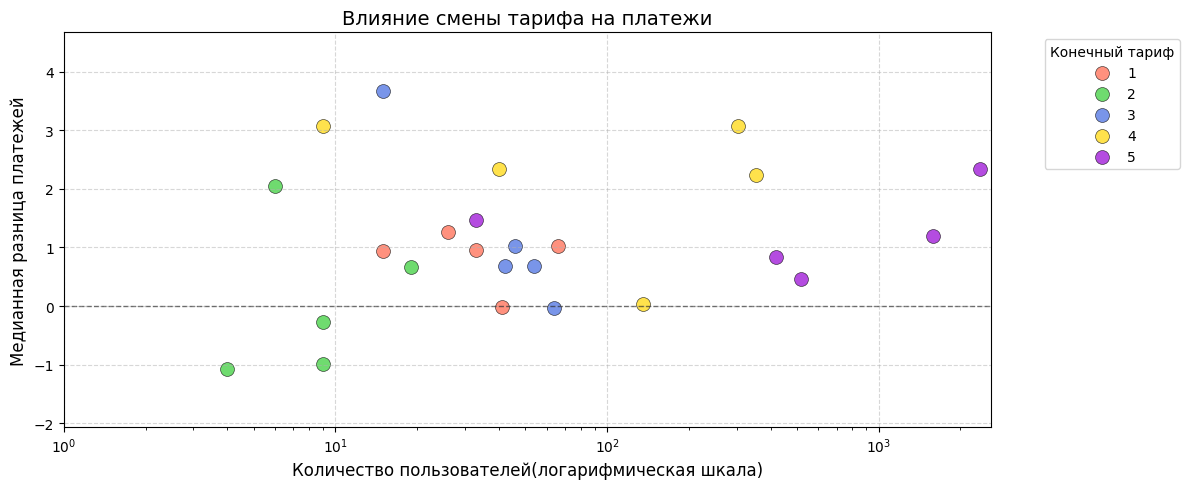

In [110]:
# Создаем scatter plot
plt.figure(figsize=(12, 5))

# Рисуем точки для каждого finish_tariff
for finish, group in new_t.groupby('Tariff_migration'):
    plt.scatter(
        x=group['SUBSCRIBER_ID'], 
        y=group['Charges_delta'],
        s=100,  # Фиксированный размер точек (можно заменить на group['users_count']/10 для масштабирования)
        c=tariff_colors[int(finish[-1])],
        label=f'Тариф {finish}',
        alpha=0.7,
        edgecolors='black',  # Черная обводка для лучшей видимости
        linewidths=0.5
    )

# Настройки осей и сетки
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)  # Линия y=0
plt.xlabel('Количество пользователей(логарифмическая шкала)', fontsize=12)
plt.ylabel('Медианная разница платежей', fontsize=12)
plt.title('Влияние смены тарифа на платежи', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Легенда и подписи
plt.legend(title='Конечный тариф', bbox_to_anchor=(1.05, 1), loc='upper left', labels = (1,2,3,4,5))
plt.xscale('log')
plt.xlim(1, 10**4)
# Автоматическое масштабирование осей с запасом
plt.xlim(0, new_t['SUBSCRIBER_ID'].max() * 1.1)
y_min = new_t['Charges_delta'].min() - 1
y_max = new_t['Charges_delta'].max() + 1
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

По медиане цена тарифа выросла для всех, исключение - группа абонентов, перешедшая на тариф 2.

3. Направления смен тарифных планов: с каких тарифных планов и на какие шли  наибольшие перетоки? Визуализировать потоки миграций на диаграмме.


In [ ]:
tariffs_stream = pd.merge(tariffs, start_tariffs, on='SUBSCRIBER_ID', how='left') \
    .merge(finish_tariffs, on='SUBSCRIBER_ID', how='left') \
    .groupby(['Start_Tariff_ID', 'Finish_Tariff_ID'], as_index=False)['SUBSCRIBER_ID'].nunique().rename(columns = {'SUBSCRIBER_ID':'id_count'})

tariffs_filtered = tariffs_stream[tariffs_stream['Start_Tariff_ID'] != tariffs_stream['Finish_Tariff_ID']]

In [ ]:
import plotly.graph_objects as go

#1. Получаем все уникальные тарифы из данных
all_tariffs = sorted(list(set(tariffs_filtered['Start_Tariff_ID']).union(
                     set(tariffs_filtered['Finish_Tariff_ID']))))

# 2. Создаем labels и маппинг тарифов на индексы
labels = [f"Тариф {t}" for t in all_tariffs]
tariff_to_index = {tariff: idx for idx, tariff in enumerate(all_tariffs)}

# 3. Создаем диаграмму Санкей
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=[tariff_colors.get(t, "rgba(150, 150, 150, 0.8") for t in all_tariffs]  # Цвета узлов
    ),
    link=dict(
        source=tariffs_filtered['Start_Tariff_ID'].map(tariff_to_index),
        target=tariffs_filtered['Finish_Tariff_ID'].map(tariff_to_index),
        value=tariffs_filtered['id_count'],
        color=[tariff_colors.get(src, "rgba(150, 150, 150, 0.4)") 
               for src in tariffs_filtered['Start_Tariff_ID']],  # Цвета связей
        hoverinfo='all',
        hovertemplate='%{source.label} → %{target.label}<br>Количество: %{value}<extra></extra>'
    )
))

fig.update_layout(
    title_text="Миграция пользователей между тарифами",
    font_size=12,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50)
)

fig.show()